In [36]:
!pip install pulp
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import Markdown, display


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


# Question 2

## Updated Costs

In [37]:
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 1500, 3000, 3200, 3900, 2200, 2200, 1100])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])

In [38]:
def plot_inventory():
  t_values = list(range(1, n_months + 1))

  plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
  plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
  plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
  plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
  plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')

  # Adding labels and legend
  plt.xlabel('Period')
  plt.ylabel('')
  plt.legend(loc='best')
  plt.title('Aggregate Plan')
  plt.grid(axis='y')

  # Show the plot
  plt.show()

In [39]:

# Create a Gurobi model
model = Model("MinimizeCost2")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

opt_results = []
for t in range(0, n_months + 1):
    row = [
        t,
        int(H[t].x),
        int(L[t].x),
        int(W[t].x),
        int(O[t].x),
        int(I[t].x),
        int(S[t].x),
        int(C[t].x),
        int(P[t].x),
        int(D[t].x),
        "{:.1f}".format(Pr[t]) if t > 0 else "-"
    ]
    opt_results.append(row)

# Slightly longer abbreviations for headers
headers = ["Period", "Hired", "LaidOff", "Workforce", "OT Hours", "Inventory", "Stockout", "Subcontract", "Production", "Demand", "Price"]

# Use a compact table format
table = tabulate(opt_results, headers=headers, tablefmt="pipe", numalign="right", stralign="right")

# Display the table in Jupyter notebook
display(Markdown(table))

mimimum_cost_updated = model.objVal

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")
# After optimizing the model with updated demand
updated_january_costs = 300 * H[1].x + 500 * L[1].x + 640 * W[1].x + 6 * O[1].x + 2 * I[1].x + 5 * S[1].x + 30 * C[1].x + 10 * P[1].x
print("updated_january_costs :", updated_january_costs)

|   Period |   Hired |   LaidOff |   Workforce |   OT Hours |   Inventory |   Stockout |   Subcontract |   Production |   Demand |   Price |
|---------:|--------:|----------:|------------:|-----------:|------------:|-----------:|--------------:|-------------:|---------:|--------:|
|        0 |       0 |         0 |          80 |          0 |        1000 |          0 |             0 |            0 |        0 |       - |
|        1 |       0 |        14 |          66 |          0 |        2140 |          0 |             0 |         2640 |     1500 |    40.0 |
|        2 |       0 |         0 |          66 |          0 |        1780 |          0 |             0 |         2640 |     3000 |    40.0 |
|        3 |       0 |         0 |          66 |          0 |        1220 |          0 |             0 |         2640 |     3200 |    40.0 |
|        4 |       0 |         0 |          66 |          0 |           0 |          0 |            40 |         2640 |     3900 |    40.0 |
|        5 |       0 |        12 |          54 |          0 |           0 |         40 |             0 |         2160 |     2200 |    40.0 |
|        6 |       0 |         6 |          48 |          0 |           0 |        320 |             0 |         1920 |     2200 |    40.0 |
|        7 |       0 |         0 |          48 |          0 |         500 |          0 |             0 |         1920 |     1100 |    40.0 |

Minimum Cost : $ 460,840.00
Total Revenue: $ 684,000.00
Profit       : $ 223,160.00
updated_january_costs : 79920.0


## Original Costs

In [40]:

### User defined variables
F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])


# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

opt_results = []
for t in range(0, n_months + 1):
    row = [
        t,
        int(H[t].x),
        int(L[t].x),
        int(W[t].x),
        int(O[t].x),
        int(I[t].x),
        int(S[t].x),
        int(C[t].x),
        int(P[t].x),
        int(D[t].x),
        "{:.1f}".format(Pr[t]) if t > 0 else "-"
    ]
    opt_results.append(row)

# Slightly longer abbreviations for headers
headers = ["Period", "Hired", "LaidOff", "Workforce", "OT Hours", "Inventory", "Stockout", "Subcontract", "Production", "Demand", "Price"]

# Use a compact table format
table = tabulate(opt_results, headers=headers, tablefmt="pipe", numalign="right", stralign="right")

# Display the table in Jupyter notebook
display(Markdown(table))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

original_january_costs = 300 * H[1].x + 500 * L[1].x + 640 * W[1].x + 6 * O[1].x + 2 * I[1].x + 5 * S[1].x + 30 * C[1].x + 10 * P[1].x
print("original_january_costs :", original_january_costs)

|   Period |   Hired |   LaidOff |   Workforce |   OT Hours |   Inventory |   Stockout |   Subcontract |   Production |   Demand |   Price |
|---------:|--------:|----------:|------------:|-----------:|------------:|-----------:|--------------:|-------------:|---------:|--------:|
|        0 |       0 |         0 |          80 |          0 |        1000 |          0 |             0 |            0 |        0 |       - |
|        1 |       0 |        15 |          65 |          0 |        2000 |          0 |             0 |         2600 |     1600 |    40.0 |
|        2 |       0 |         0 |          65 |          0 |        1600 |          0 |             0 |         2600 |     3000 |    40.0 |
|        3 |       0 |         0 |          65 |          0 |        1000 |          0 |             0 |         2600 |     3200 |    40.0 |
|        4 |       0 |         1 |          64 |          0 |           0 |        220 |            20 |         2560 |     3800 |    40.0 |
|        5 |       0 |         0 |          64 |          0 |         140 |          0 |             0 |         2560 |     2200 |    40.0 |
|        6 |       0 |         0 |          64 |          0 |         500 |          0 |             0 |         2560 |     2200 |    40.0 |

Minimum Cost : $ 422,660.00
Total Revenue: $ 640,000.00
Profit       : $ 217,340.00
original_january_costs : 79100.0


# Question 3

In [42]:
# Calculate the impact
impact_on_january_costs = updated_january_costs - original_january_costs

print(f"Impact on January Costs: $ {impact_on_january_costs:,.2f}")

Impact on January Costs: $ 820.00


# Question 4

In [43]:
# mimimum costs between original and updated
460840 - 422660 

38180

Cost difference for Feb through June: $ -79,100.00


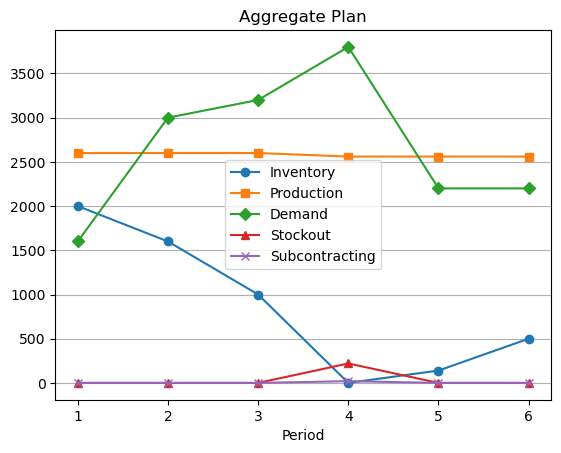

In [44]:
# Actual inventory at the end of January
actual_inventory_Jan = 1000

# Update the initial inventory constraint
model.getConstrByName("Inventory_Beg").setAttr(GRB.Attr.RHS, actual_inventory_Jan)

# Re-optimize the model
model.optimize()

# Calculate the total cost for February through June in the updated plan
total_cost_updated_plan = sum(300*H[t].x + 500*L[t].x + 640*W[t].x + 6*O[t].x + 2*I[t].x + 5*S[t].x + 30*C[t].x + 10*P[t].x for t in range(2, 7))

# calculated the total cost for the original plan in a similar way
total_cost_original_plan = 422660

# Calculate the cost difference
cost_difference = total_cost_updated_plan - total_cost_original_plan

print(f"Cost difference for Feb through June: $ {cost_difference:,.2f}")

# Plot the inventory and other relevant information
plot_inventory()